# messy work 

In [611]:
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit_aer import Aer
from qiskit.compiler import transpile
from qiskit.quantum_info import Statevector, DensityMatrix, random_statevector, partial_trace

from scipy.linalg import sqrtm

import numpy as np

import secrets, time, uuid, hashlib

In [310]:
wave_functions = []
n = 3

i = 0 
while i < 12: 
    wave_functions.append(random_statevector(dims = 2))
    i += 1

num_wave_functions = len(wave_functions)
quotient = num_wave_functions // n 
groups = [] 

i = 0 
while i < num_wave_functions: 
    groups.append([wave_functions[i:i+n]])
    i += n


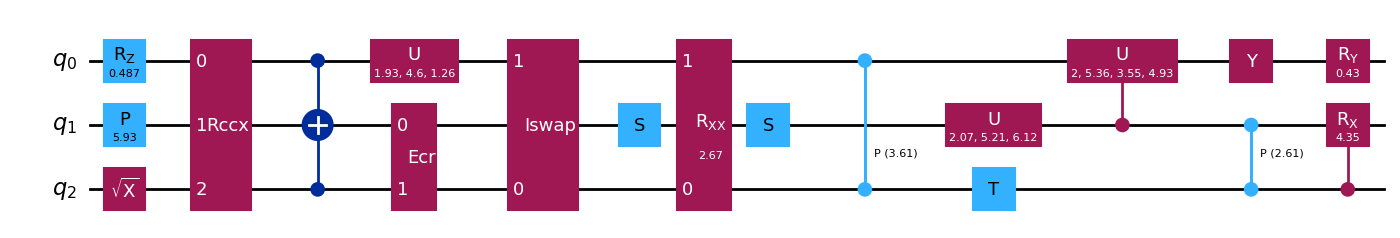

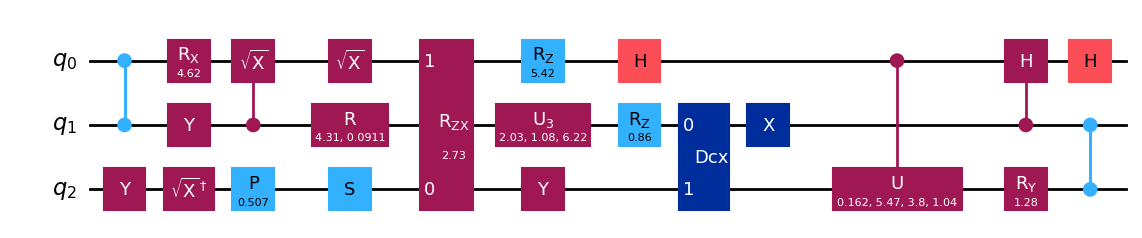

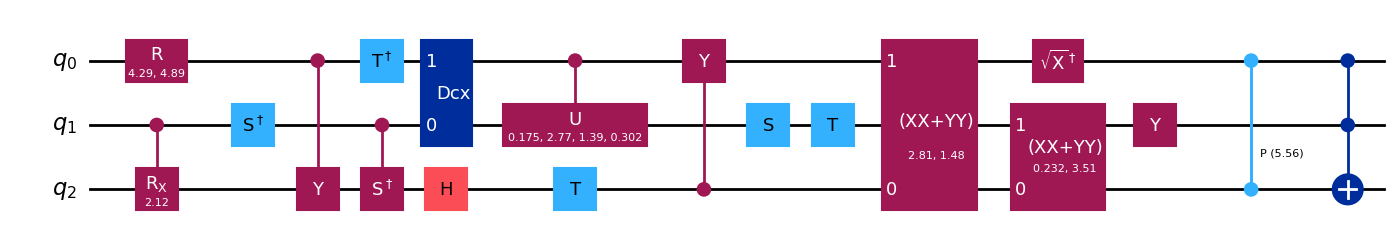

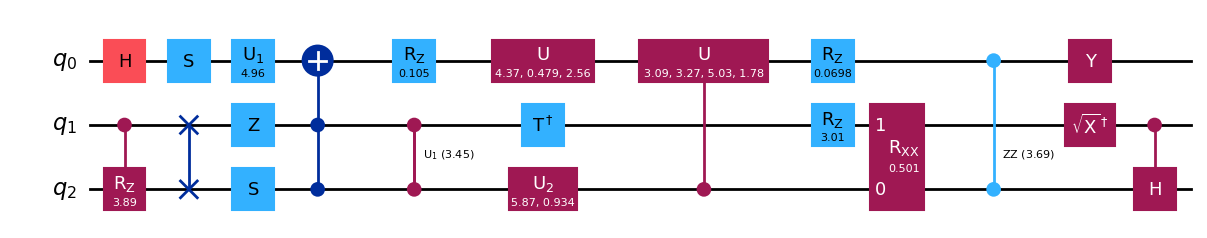

In [311]:
def generate_seed():

    entropy = secrets.token_bytes(16) + time.time_ns().to_bytes(8, 'big') + uuid.uuid4().bytes
    seed = int(hashlib.sha256(entropy).hexdigest(), 16) % 2**32

    return seed

seeds = []
circuits = []

for i in range(len(groups)): 

    num_wave_functions = len(groups[i][0])

    seed = generate_seed() 
    circuit = random_circuit(num_wave_functions, depth = 10, seed = seed)

    circuits.append(circuit)
    seeds.append(seed)

for i in circuits: 

    display(i.draw('mpl'))

In [348]:
simulator = Aer.get_backend('statevector_simulator')
final_wave_functions = []
ancillary_wave_functions = []

def cycle(arr): 
    return [arr[-1]] + arr[:-1]

def run(current_wave_funcs, i):

    result_wave_functions = []

    num_wave_functions = len(current_wave_funcs)

    initial_wave_function = current_wave_funcs[0]

    for wf in current_wave_funcs[1:]:
        initial_wave_function = initial_wave_function.tensor(wf)

    main_circuit = circuits[i]
    initialization_circuit = QuantumCircuit(num_wave_functions)
    initialization_circuit.initialize(initial_wave_function.data, 
                                        [j for j in range(num_wave_functions)])

    full_circuit = initialization_circuit.compose(main_circuit)
    transpiled_circuit = transpile(full_circuit, simulator)
    result = simulator.run(transpiled_circuit).result()
    final_wave_function = result.get_statevector()
    result_wave_functions.append(final_wave_function)

    return result_wave_functions

In [369]:
final_wave_functions = []

for i in range(len(groups)): 
    wave_functions = groups[i][0]

    ancillary_wave_functions = []
    j = 0 
    while j < len(wave_functions): 
        wave_functions = cycle(wave_functions)
        output_wave_functions = run(wave_functions, i)

        ancillary_wave_functions.append(output_wave_functions)
        j += 1

    final_wave_functions.append(ancillary_wave_functions)

final_wave_functions



[[[Statevector([-0.25613633+0.32774306j,  0.23422025-0.28308884j,
                -0.39691379-0.15621598j,  0.49390867-0.18904525j,
                -0.17109093+0.0697181j ,  0.19912517-0.20985667j,
                 0.25417672-0.19345157j,  0.02547783+0.09925005j],
               dims=(2, 2, 2))],
  [Statevector([-0.26256228-0.06308312j,  0.42090276-0.33149657j,
                -0.52947756+0.2566532j , -0.15983662-0.20145842j,
                 0.03296775-0.22363692j, -0.04079015-0.1362743j ,
                 0.13668912+0.00076573j,  0.0062794 +0.37097583j],
               dims=(2, 2, 2))],
  [Statevector([-0.26922115+0.26018298j,  0.26294899-0.21470142j,
                -0.24566665+0.32456488j,  0.07279218+0.16839026j,
                -0.07212507-0.29372576j,  0.65798607-0.00799539j,
                -0.1108839 -0.06699767j, -0.05222618+0.03520697j],
               dims=(2, 2, 2))]],
 [[Statevector([-0.15376173+0.47318073j, -0.54043931+0.052017j  ,
                 0.19213673+0.1413335j 

In [420]:
density_matrices = []

for i in final_wave_functions: 

    coupled_density_matrices = []
    for j in range(len(i)): 
        coupled_density_matrices.append(DensityMatrix(i[j][0]))

    density_matrices.append(coupled_density_matrices)

for i in density_matrices: 
    for j in i: 
        display(j.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [445]:
combined_string = ''.join(map(str, [11515, 151675, 151676]))
hash_object = hashlib.sha256(combined_string.encode())
hex_dig = hash_object.hexdigest()[:5]
seed = int(hex_dig, 16)

seed

randomized_pure_state = random_statevector(dims = 8, seed = seed)
randomized_density_matrix = DensityMatrix(randomized_pure_state)

randomized_density_matrix.draw('latex')

fidelities = []

def calculate_fidelitiy(rho, sigma): 

    sqrt_rho = sqrtm(rho)
    product = np.dot(sqrt_rho, np.dot(sigma, sqrt_rho))
    sqrt_product = sqrtm(product)
    trace = np.trace(sqrt_product)
    
    return np.real(trace)**2

for coupled_states in density_matrices: 
    coupled_fidelities = []

    for matrix in coupled_states: 

        fidelity = calculate_fidelitiy(matrix, randomized_density_matrix)
        coupled_fidelities.append(fidelity)

    fidelities.append(coupled_fidelities)

In [430]:
full_eigenvalues, full_eigenvectors = [], []

for coupled_states in density_matrices:
    coupled_eigenvalues, coupled_eigenvectors = [], []
    
    for matrix in coupled_states: 

        is_unit_trace = np.isclose(np.trace(matrix), 1.0)
        is_hermitian = np.allclose(matrix, np.matrix(matrix.data).getH())

        if not is_unit_trace: 
            raise Exception("Tr(ρ) ≠ 1")
        if not is_hermitian: 
            raise Exception("ρ not Hermitian")

        eigenvalues, eigenvectors = np.linalg.eigh(matrix.data)
        coupled_eigenvalues.append([eigenvalues])
        coupled_eigenvectors.append([eigenvectors])

        reconstructed_matrix = sum(eigenvalues[i] * np.outer(eigenvectors[:, i], 
                                    np.conj(eigenvectors[:, i])) for i in range(len(eigenvalues)))

        spectral_decomp_worked = np.allclose(matrix, reconstructed_matrix)

        if not spectral_decomp_worked: 
            raise Exception("spectral decomposition failed")

    full_eigenvalues.append(coupled_eigenvalues)
    full_eigenvectors.append(coupled_eigenvectors)

full_eigenvalues

[[[array([-5.72406448e-17, -2.90986350e-17, -5.72221078e-18, -3.00407753e-18,
           1.44842918e-18,  1.16876200e-17,  1.90403505e-16,  1.00000000e+00])],
  [array([-1.44197608e-16, -6.55498690e-17, -6.92984042e-18, -2.16509633e-18,
           9.59647127e-19,  6.64067586e-18,  6.20830989e-17,  1.00000000e+00])],
  [array([-1.68633894e-16, -3.89003594e-17, -4.84011078e-19,  6.65496856e-19,
           1.94132499e-18,  1.45048221e-17,  1.90219015e-16,  1.00000000e+00])]],
 [[array([-8.65826795e-17, -3.28111908e-17, -4.69621587e-18, -1.68452445e-18,
           4.83669216e-18,  1.32516578e-17,  7.78995773e-17,  1.00000000e+00])],
  [array([-1.41646663e-16, -1.06915253e-16, -5.05313886e-18, -4.32761043e-21,
           4.14742498e-19,  1.66229264e-17,  1.18073867e-16,  1.00000000e+00])],
  [array([-2.69434040e-16, -1.56004267e-16, -4.07280257e-17, -1.79767404e-18,
           3.04857212e-18,  5.65219435e-18,  1.27808889e-17,  1.00000000e+00])]],
 [[array([-3.89597483e-17, -8.96306297e-18, 

In [449]:
weights = [] 

for values in fidelities: 
    coupled_weights = []
    total = 0 
    for fidelity in values: 
        total += fidelity 

    for fidelity in values: 
        coupled_weights.append(fidelity / total)

    weights.append(coupled_weights) 


In [469]:
mixed_density_matrices = []

for coupled_states_idx in range(len(density_matrices)):
    mixed_density_matrix = np.zeros((2**3, 2**3), dtype=np.complex128)

    for matrix_idx in range(len(density_matrices[coupled_states_idx])):
        current_matrix = density_matrices[coupled_states_idx][matrix_idx].data

        mixed_density_matrix += weights[coupled_states_idx][matrix_idx] * current_matrix
        
    mixed_density_matrices.append(DensityMatrix(mixed_density_matrix))

for i in mixed_density_matrices: 
    display(i.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [472]:
full_eigenvalues, full_eigenvectors = [], []

for matrix in mixed_density_matrices: 

    is_unit_trace = np.isclose(np.trace(matrix), 1.0)
    is_hermitian = np.allclose(matrix, np.matrix(matrix.data).getH())

    if not is_unit_trace: 
        raise Exception("Tr(ρ) ≠ 1")
    if not is_hermitian: 
        raise Exception("ρ not Hermitian")

    eigenvalues, eigenvectors = np.linalg.eigh(matrix.data)
    full_eigenvalues.append([eigenvalues])
    full_eigenvectors.append([eigenvectors])

    reconstructed_matrix = sum(eigenvalues[i] * np.outer(eigenvectors[:, i], 
                                np.conj(eigenvectors[:, i])) for i in range(len(eigenvalues)))

    spectral_decomp_worked = np.allclose(matrix, reconstructed_matrix)

    if not spectral_decomp_worked: 
        raise Exception("spectral decomposition failed")
    
full_eigenvalues

[[array([-1.45466018e-16, -1.26816109e-18,  8.54612808e-18,  3.79449328e-17,
          1.05485556e-16,  7.06194581e-02,  1.86802503e-01,  7.42578039e-01])],
 [array([-3.36090945e-17, -1.20799106e-17,  1.40067791e-17,  3.03226615e-17,
          1.03523652e-16,  4.95637271e-02,  1.66037307e-01,  7.84398966e-01])],
 [array([-3.92677001e-17, -2.06665150e-17, -1.24775077e-17,  7.32452500e-18,
          6.94844210e-17,  1.31979179e-01,  1.74880253e-01,  6.93140568e-01])],
 [array([-8.99857208e-17, -3.96868729e-17, -2.64345299e-19,  2.30246280e-17,
          6.09987698e-17,  3.02062122e-02,  1.22553720e-01,  8.47240067e-01])]]

In [547]:
entropies = []

def calculate_entropy(eigenvalues): 

    eigenvalues = np.array(eigenvalues)
    non_zero_eigenvalues = eigenvalues[eigenvalues > 0]

    entropy = -np.sum(non_zero_eigenvalues * np.log(non_zero_eigenvalues))

    return entropy

for eigenlist in full_eigenvalues: 
    entropies.append(calculate_entropy(eigenlist))

entropies, full_eigenvalues, full_eigenvectors

([0.7215840025467424,
  0.6375225946330594,
  0.8262547071986523,
  0.5034263906335903],
 [[array([-1.45466018e-16, -1.26816109e-18,  8.54612808e-18,  3.79449328e-17,
           1.05485556e-16,  7.06194581e-02,  1.86802503e-01,  7.42578039e-01])],
  [array([-3.36090945e-17, -1.20799106e-17,  1.40067791e-17,  3.03226615e-17,
           1.03523652e-16,  4.95637271e-02,  1.66037307e-01,  7.84398966e-01])],
  [array([-3.92677001e-17, -2.06665150e-17, -1.24775077e-17,  7.32452500e-18,
           6.94844210e-17,  1.31979179e-01,  1.74880253e-01,  6.93140568e-01])],
  [array([-8.99857208e-17, -3.96868729e-17, -2.64345299e-19,  2.30246280e-17,
           6.09987698e-17,  3.02062122e-02,  1.22553720e-01,  8.47240067e-01])]],
 [[array([[-0.43653551+0.j        ,  0.09355734+0.j        ,
           -0.10779067+0.j        , -0.13420957+0.j        ,
            0.65456054-0.j        ,  0.42224714-0.j        ,
            0.01842631+0.j        , -0.4049334 +0.j        ],
          [-0.65321394+0.2448

In [594]:
sorted_indices = np.argsort(entropies)[::-1]
		
entropies = np.array(entropies)
eigenvalues = np.array(full_eigenvalues)
eigenvectors = np.array(full_eigenvectors)

eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[sorted_indices]

non_zero_eigenvalue_idxs = []
for eigenlist in eigenvalues: 
    non_zero_eigenvalue_idxs.append(np.where(eigenlist[0] > 1e-10)[0])

organized_eigenvectors = []
statevectors = []

for idx in range(len(eigenvectors)):
    allowed_idxs = non_zero_eigenvalue_idxs[idx]

    organized_eigenvectors.append(eigenvectors[idx][0][allowed_idxs])

for coupled_statevectors in organized_eigenvectors: 
    for statevector in coupled_statevectors: 
        statevectors.append(Statevector(statevector))

for i in statevectors: 
    display(i.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [654]:

def n_to_single(statevector): 

    single_qubit_density_matrix = partial_trace(statevector, [i for i in range(3 - 1)])
    eigenvalues, eigenvectors = np.linalg.eigh(single_qubit_density_matrix.data)

    sorted_eigenvalues = np.array(eigenvalues)[np.argsort(eigenvalues)]
    sorted_eigenvectors = np.array(eigenvectors)[np.argsort(eigenvalues)]

    return Statevector(sorted_eigenvectors[0])

statevectors_final = []

for statevec in statevectors: 
    statevectors_final.append(n_to_single(statevec))

statevectors_final


[Statevector([-0.53158248+0.j, -0.84700653+0.j],
             dims=(2,)),
 Statevector([-0.89706714+0.j, -0.44189426+0.j],
             dims=(2,)),
 Statevector([-0.9466998 +0.j, -0.32211719+0.j],
             dims=(2,)),
 Statevector([-0.94326715+0.j, -0.33203477+0.j],
             dims=(2,)),
 Statevector([ 0.59062773+0.j, -0.80694416+0.j],
             dims=(2,)),
 Statevector([ 0.36869405+0.j, -0.92955081+0.j],
             dims=(2,)),
 Statevector([-0.73925792+0.j, -0.6734224 +0.j],
             dims=(2,)),
 Statevector([-0.25746206+0.j, -0.96628841+0.j],
             dims=(2,)),
 Statevector([-0.13834006+0.j, -0.99038479+0.j],
             dims=(2,)),
 Statevector([-0.83686138+0.j,  0.54741486+0.j],
             dims=(2,)),
 Statevector([ 0.35716749+0.j, -0.93404035+0.j],
             dims=(2,)),
 Statevector([-0.79980184+0.j,  0.60026412+0.j],
             dims=(2,))]

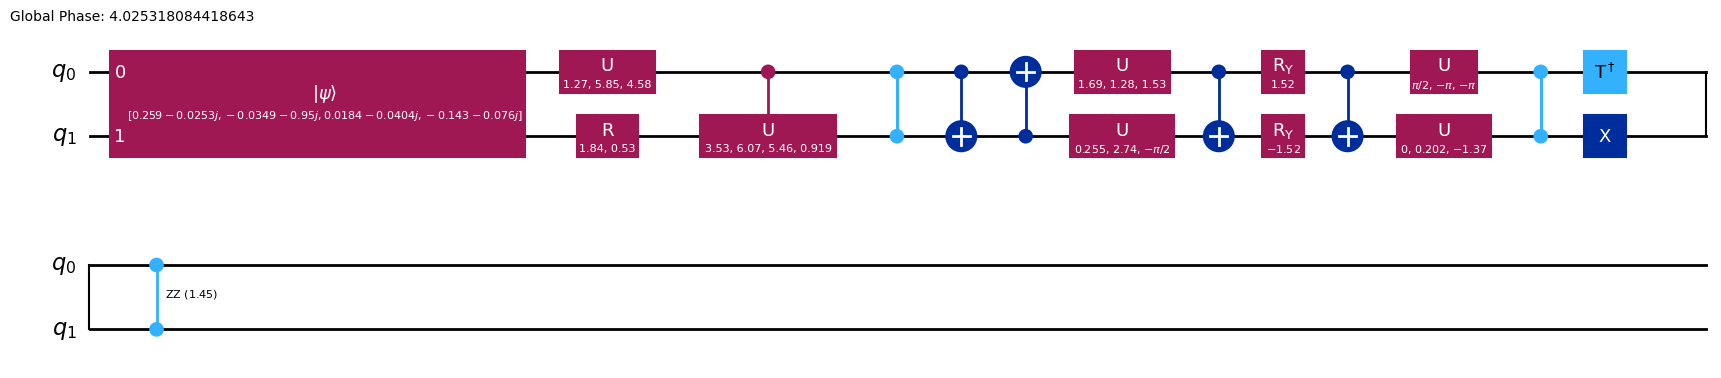

In [139]:
simulator = Aer.get_backend('statevector_simulator')

initialization_circuit = QuantumCircuit(2)
initialization_circuit.initialize(initial_wave_function.data, [0, 1])

initialization_circuit.draw('mpl')
full_circuit = initialization_circuit.compose(circuit)

transpiled_circuit = transpile(full_circuit, simulator)
result = simulator.run(transpiled_circuit).result()
final_state_vector = result.get_statevector()

transpiled_circuit.draw('mpl')




In [140]:
final_state_vectors = []

for i in range(len(groups)): 

    wave_functions = groups[i][0]
    num_wave_functions = len(wave_functions)
    initial_wave_function = groups[i][0][0]

    for wf in wave_functions[1:]:
        initial_wave_function = initial_wave_function.tensor(wf)

    main_circuit = circuits[i]
    initialization_circuit = QuantumCircuit(num_wave_functions)
    initialization_circuit.initialize(initial_wave_function.data, 
                                        [i for i in range(num_wave_functions)])

    full_circuit = initialization_circuit.compose(main_circuit)
    transpiled_circuit = transpile(full_circuit, simulator)
    result = simulator.run(transpiled_circuit).result()
    final_state_vector = result.get_statevector()
    final_state_vectors.append(final_state_vector)

for i in final_state_vectors: 
    display(i.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [408]:
density_matrices = []

for i in final_state_vectors:
    density_matrices.append(DensityMatrix(i))

for i in density_matrices: 
    display(i.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
full_eigenvalues, full_eigenvectors = [], []

for matrix in density_matrices: 

    trace = np.trace(matrix)
    is_unit_trace = np.isclose(trace, 1.0)
    is_hermitian = np.allclose(matrix, np.matrix(matrix.data).getH())

    if not is_unit_trace: 
        raise Exception("Tr(ρ) ≠ 1")
    if not is_hermitian: 
        raise Exception("ρ not Hermitian")

    eigenvalues, eigenvectors = np.linalg.eigh(matrix.data)
    full_eigenvalues.append([eigenvalues])
    full_eigenvectors.append([eigenvectors])

    reconstructed_matrix = sum(eigenvalues[i] * np.outer(eigenvectors[:, i], 
                                np.conj(eigenvectors[:, i])) for i in range(len(eigenvalues)))

    spectral_decomp_worked = np.allclose(matrix, reconstructed_matrix)

    if not spectral_decomp_worked: 
        raise Exception("spectral decomposition failed")